<a href="https://colab.research.google.com/github/VedSher/AD_Lab_Assignments/blob/main/ADLabAssignmentonCNN(bone_fracture_dataset).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("osamajalilhassan/bone-fracture-dataset")

print("Path to dataset files:", path)

100%|██████████| 173M/173M [00:03<00:00, 51.9MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/osamajalilhassan/bone-fracture-dataset/versions/1


Found 7571 images belonging to 1 classes.
Found 1892 images belonging to 1 classes.
Training VGG16...
Epoch 1/5
2/2 ━━━━━━━━━━━━━━━━━━━━ 72s 51s/step - accuracy: 0.9762 - loss: 0.3821 - val_accuracy: 1.0000 - val_loss: 0.2324
Epoch 2/5
2/2 ━━━━━━━━━━━━━━━━━━━━ 66s 35s/step - accuracy: 1.0000 - loss: 0.2670 - val_accuracy: 1.0000 - val_loss: 0.1401
Epoch 3/5
2/2 ━━━━━━━━━━━━━━━━━━━━ 53s 35s/step - accuracy: 1.0000 - loss: 0.1655 - val_accuracy: 1.0000 - val_loss: 0.0890
Epoch 4/5
2/2 ━━━━━━━━━━━━━━━━━━━━ 83s 36s/step - accuracy: 1.0000 - loss: 0.1061 - val_accuracy: 1.0000 - val_loss: 0.0582
Epoch 5/5
2/2 ━━━━━━━━━━━━━━━━━━━━ 67s 51s/step - accuracy: 1.0000 - loss: 0.0813 - val_accuracy: 1.0000 - val_loss: 0.0392
Training ResNet50...
Epoch 1/5
2/2 ━━━━━━━━━━━━━━━━━━━━ 31s 16s/step - accuracy: 0.8812 - loss: 0.4941 - val_accuracy: 1.0000 - val_loss: 0.1874
Epoch 2/5
2/2 ━━━━━━━━━━━━━━━━━━━━ 37s 11s/step - accuracy: 1.0000 - loss: 0.1726 - val_accuracy: 1.0000 - val_loss: 0.0693
Epoch 3/5

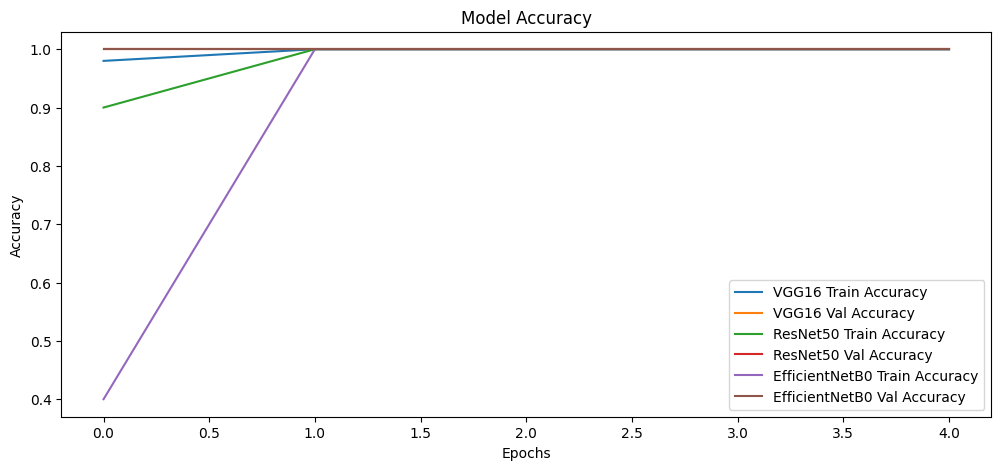

In [3]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.applications import VGG16, ResNet50, EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define constants
IMG_SIZE = (224, 224)
BATCH_SIZE = 16  # Reduce batch size to speed up per-epoch processing
EPOCHS = 5  # Reduce number of epochs to decrease training time
DATASET_PATH = path  # Update this to your dataset path

def load_data():
    datagen = ImageDataGenerator(rescale=1.0/255, validation_split=0.2)

    train_generator = datagen.flow_from_directory(
        DATASET_PATH, target_size=IMG_SIZE, batch_size=50, class_mode='binary', subset='training', shuffle=True)

    val_generator = datagen.flow_from_directory(
        DATASET_PATH, target_size=IMG_SIZE, batch_size=50, class_mode='binary', subset='validation', shuffle=False)

    # Limit training data to the first 50 images
    train_generator = next(iter(train_generator))
    val_generator = next(iter(val_generator))

    return train_generator, val_generator

def build_model(base_model):
    base_model.trainable = False  # Freeze the base model
    x = GlobalAveragePooling2D()(base_model.output)  # Replace Flatten with GAP to reduce computation
    x = Dense(64, activation='relu')(x)  # Reduce Dense layer size
    x = Dropout(0.3)(x)  # Reduce dropout rate
    x = Dense(1, activation='sigmoid')(x)  # Binary classification
    return Model(inputs=base_model.input, outputs=x)

def train_model(model, train_generator, val_generator, epochs=EPOCHS):
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    history = model.fit(train_generator[0], train_generator[1], validation_data=(val_generator[0], val_generator[1]), epochs=epochs, verbose=1)
    return history

def plot_results(histories):
    plt.figure(figsize=(12, 5))
    for name, history in histories.items():
        plt.plot(history.history['accuracy'], label=f'{name} Train Accuracy')
        plt.plot(history.history['val_accuracy'], label=f'{name} Val Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

# Load data
train_generator, val_generator = load_data()

# Define models
models = {
    "VGG16": VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3)),
    "ResNet50": ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3)),
    "EfficientNetB0": EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
}

# Train each model and store history
histories = {}
for name, base_model in models.items():
    print(f"Training {name}...")
    model = build_model(base_model)
    histories[name] = train_model(model, train_generator, val_generator, epochs=EPOCHS)

# Separate plotting step
if histories:
    plot_results(histories)
